### The IDEAS project is supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Integrated Digital Earth Analysis System (IDEAS) API Demonstration

This notebook highlights some of the analytics and visualization capabilities of IDEAS with four use cases:
- Pakistan flooding occurring from June through September, 2022
- Hurricane Ian as it makes landfall over Florida in September, 2022
- France storm in January 2022
- LIS model data over the Mississippi river basin in January, 2020

## Libraries

The following libraries are needed to support accessing IDEAS API. The functions called in this notebook are in the `ideas_modules` folder

### Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import requests
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import box
from tabulate import tabulate
from IPython.display import Image
from owslib.util import Authentication
from owslib.wms import WebMapService
from PIL import Image as I
from PIL import ImageDraw

import ideas_modules.plotting as plotting
import ideas_modules.ideas_processing as ideas_processing

## Data Inventory
The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry point to access IDEAS API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov/nexus'

In [3]:
ideas_datasets = [
    'LIS-ESoil-tavg',
    'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed',
    'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed_clim',
]

url = f'{BASE_URL}/list'
print('url\n', url); print()
r = requests.get(url, verify=False).json()
inventories = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']]
inventories.sort_values('title')
print(tabulate( inventories[ inventories['title'].isin(ideas_datasets) ], headers="keys", showindex=False ))

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/list

title                                                           iso_start                 iso_end
--------------------------------------------------------------  ------------------------  ------------------------
GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed       2018-10-01T00:00:00+0000  2022-10-02T00:00:00+0000
GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed_clim  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000
LIS-ESoil-tavg                                                  2019-12-01T00:00:00+0000  2020-01-31T00:00:00+0000


## IDEAS API

### API List
The capabilities endpoint is used get a list of API offered by IDEAS.

In [4]:
url = f'{BASE_URL}/capabilities'
print('url\n', url); print()

r = requests.get(url, verify=False).json()
apis = pd.DataFrame(r)[['name', 'path', 'description']]
apis.sort_values('name')

print(tabulate(apis, headers="keys", showindex=False))

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/capabilities

name                                        path                           description
------------------------------------------  -----------------------------  --------------------------------------------------------------------------------------------------------------------
Capabilities                                /capabilities                  Lists the current capabilities of this Nexus system
Correlation Map                             /correlationMap                Computes a correlation map between two datasets given an arbitrary geographical area and time range
Daily Difference Average                    /dailydifferenceaverage        Subtracts data in box in Dataset 1 from Dataset 2, then averages the difference per day.
Data In-Bounds Search                       /datainbounds                  Fetches point values for a given dataset and geographical area
Dataset List                                /list    

# Pakistan Flood 2022

Find the peak of the flood using GPM precipitation data and visualize it.

- data set: GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed
- spatial bounds:  63, 23, 75, 33
- temporal bounds: 2022-06-01 to 2022-09-25
- area of interest: Pakistan

In [5]:
bb_pakistan_flood       = {'min_lon': 66, 'max_lon': 75, 'min_lat': 23, 'max_lat': 35}
start_pakistan_flood    = datetime(2022, 6, 1)
end_pakistan_flood      = datetime(2022, 9, 25)
global_precipitation_dataset  = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed'
pakistan_parameters = (BASE_URL, global_precipitation_dataset, bb_pakistan_flood, start_pakistan_flood, end_pakistan_flood)

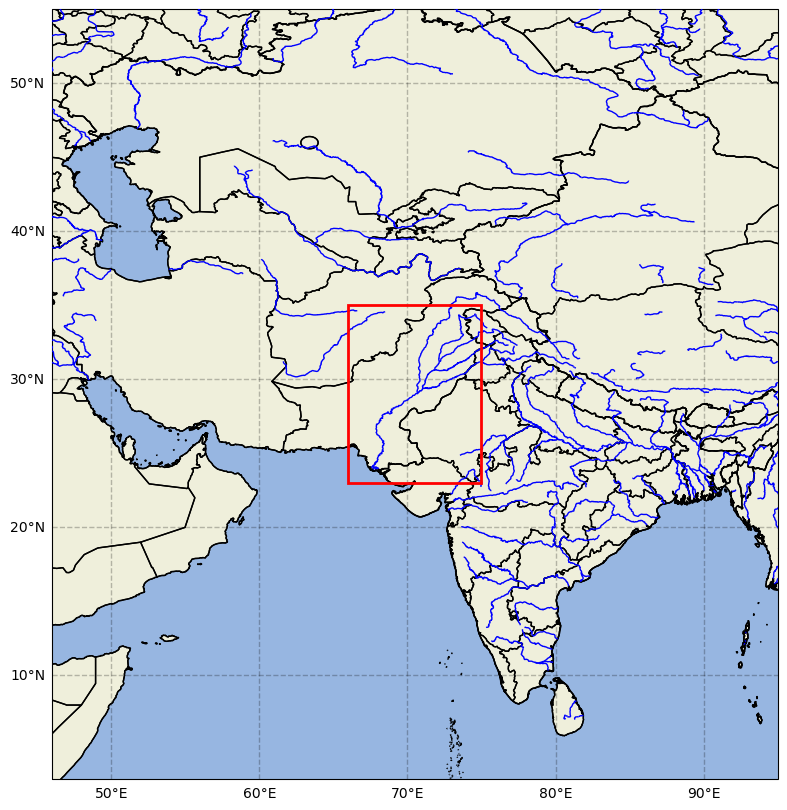

In [6]:
plotting.map_box(bb_pakistan_flood)

#### GPM Mean From 2022-08-01 to 2022-09-25

In [7]:
pakistan_timeseries = ideas_processing.spatial_timeseries(*pakistan_parameters)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&minLon=66&minLat=23&maxLon=75&maxLat=35&startTime=2022-06-01T00:00:00Z&endTime=2022-09-25T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 4.8170932499924675 seconds


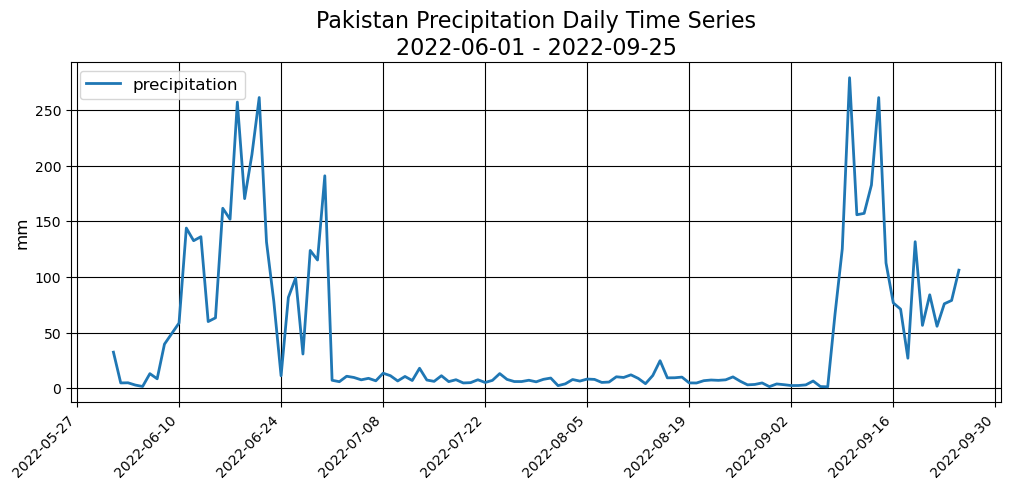

In [8]:
title = f'Pakistan Precipitation Daily Time Series\n{str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.timeseries_plot([(pakistan_timeseries['maximum'], 'precipitation')], '', 'mm', title)

**For more context, in the 2021 water year (October 1st 2020 to Sept 30th 2021), the state of California received about 300 mm of precipitation. This is only slightly more than the precipitation Pakistan was receiving some days during the floods.**

#### Data Subsetting

Fetches point values for a given dataset and geographical area.

In [9]:
pakistan_date = datetime(2022, 9, 12)
pakistan_subset_data = ideas_processing.data_subsetting(BASE_URL, global_precipitation_dataset, bb_pakistan_flood, pakistan_date, pakistan_date)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&b=66,23,75,35&startTime=2022-09-12T00:00:00Z&endTime=2022-09-12T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.8431401670095511 seconds


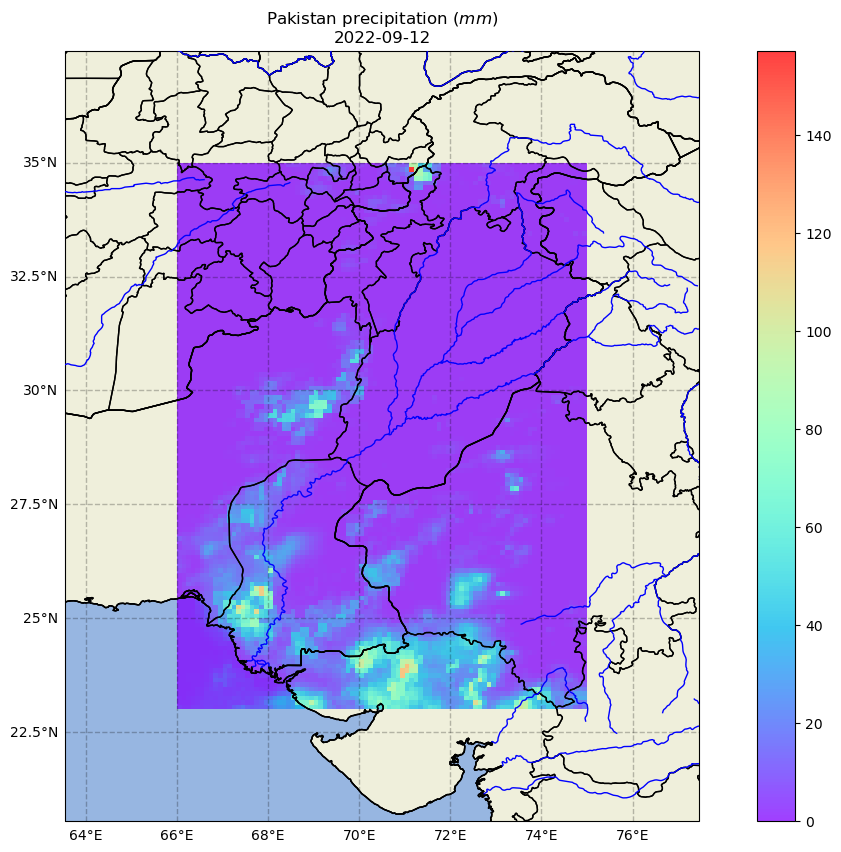

In [10]:
plotting.map_data(pakistan_subset_data[0], f'Pakistan precipitation ($mm$)\n{str(pakistan_date)[:10]}')

#### IDEAS WMS Visual GPM Precipitation 2022-09-12

In [11]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'IMERG_Precipitation_Rate',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(66,23,75,35),  # Bounds
                 size=(500, 500),  # Image size
                 time='2022-09-12',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

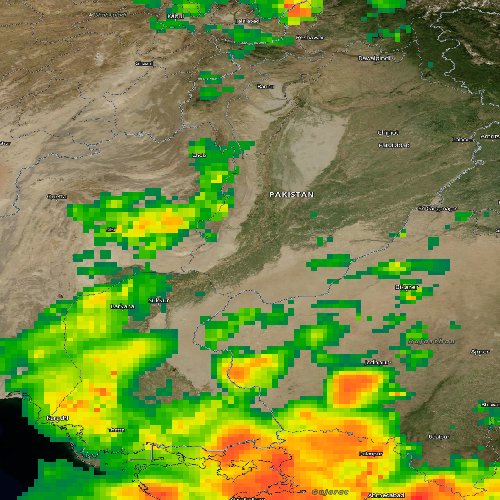

In [12]:
# View image
Image(img.read())

#### IDEAS WMS Animation 2022-08-01 to 2022-09-30

In [13]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['MODIS_Aqua_CorrectedReflectance_TrueColor',
          'IMERG_Precipitation_Rate',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2022, 8, 1)
edate = datetime(2022, 9, 30)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(66,23,75,35),  # Bounds
                     size=(500,500),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'IMERG Precipitation Rate   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('IMERG_Precipitation_Rate.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)


KeyboardInterrupt



In [ ]:
Image('IMERG_Precipitation_Rate.gif')

#### Temporal Mean

Computes a Latitude/Longitude Time Average plot given an arbitrary geographical area and time range

In [ ]:
pakistan_timeavg_data = ideas_processing.temporal_mean(*pakistan_parameters)

In [ ]:
pakistan_timeavg_title = f'Pakistan average precipitation ($mm$)\n{str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.map_data(pakistan_timeavg_data, pakistan_timeavg_title)

#### Maxima and Minima Map

Computes a map of maxmima and minima of a field given an arbitrary geographical area and time range.

In [ ]:
pakistan_max_min_data = ideas_processing.max_min_map_spark(*pakistan_parameters)

In [ ]:
pakistan_max_title = f'Pakistan maximum precipitation ($mm$)\n{str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.map_data(pakistan_max_min_data.maxima, pakistan_max_title)

#### Temporal Variance

Computes a map of the temporal variance of a field given an arbitrary geographical area and time range.

In [ ]:
pakistan_variance_data = ideas_processing.temporal_variance(*pakistan_parameters)

In [ ]:
pakistan_variance_title = f'Pakistan precipitation variance ($mm^2/s^2$)\n\
    {str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.map_data(pakistan_variance_data, pakistan_variance_title)

#### Daily Difference Average

Subtracts data in box in Dataset 1 from Dataset 2 (i.e. climatology), then averages the difference per day.

In [ ]:
global_precipitation_computed_climatology = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed_clim'
pakistan_daily_diff_data = ideas_processing.daily_diff(BASE_URL, global_precipitation_dataset, global_precipitation_computed_climatology, bb_pakistan_flood, start_pakistan_flood, end_pakistan_flood)

In [ ]:
plotting.timeseries_plot([(pakistan_daily_diff_data['mean'], 'mean'), (pakistan_daily_diff_data['std'], 'std')], '', 'mm', title='Pakistan Precipitation Anomalies')

## Hurricane Ian Florida Landfall

In [ ]:
bb_hurricane_ian      = {'min_lon': -87, 'max_lon': -72, 'min_lat': 18, 'max_lat': 35}
start_hurricane_ian   = datetime(2022, 9, 24)
end_hurricane_ian     = datetime(2022, 10, 2)
ian_parameters = (BASE_URL, global_precipitation_dataset, bb_hurricane_ian, start_hurricane_ian, end_hurricane_ian)

In [ ]:
# Plot a box around our spatial bounds
plotting.map_box(bb_hurricane_ian)

In [ ]:
ian_timeseries = ideas_processing.spatial_timeseries(*ian_parameters)

In [ ]:
ian_title = f'Hurricane Ian Precipitation Time Series\n{str(start_hurricane_ian)[:10]} - {str(end_hurricane_ian)[:10]}'
plotting.timeseries_plot([(ian_timeseries.maximum, 'precipitation')], '', 'mm', ian_title)

In [ ]:
ian_start = datetime(2022,9,25)
ian_end = datetime(2022,10,1)
ian_precipitation_data = ideas_processing.temporal_mean(BASE_URL, global_precipitation_dataset, bb_hurricane_ian, ian_start, ian_end)

In [ ]:
ian_title = f'Precipitation average ($mm$)\n{str(ian_start)[:10]} - {str(ian_end)[:10]}'
plotting.map_data(ian_precipitation_data, ian_title)

#### Daily Difference Average

Subtracts data in box in Dataset 1 from Dataset 2 (i.e. climatology), then averages the difference per day.

In [ ]:
ian_daily_diff_data = ideas_processing.daily_diff(BASE_URL, global_precipitation_dataset, global_precipitation_computed_climatology, bb_hurricane_ian, start_hurricane_ian, end_hurricane_ian)

In [ ]:
plotting.timeseries_plot([(ian_daily_diff_data['mean'], 'mean'), (ian_daily_diff_data['std'], 'std')], '', 'mm', title='Hurricane Ian Precipitation Anomalies')

In [ ]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'IMERG_Precipitation_Rate',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-87, 18, -72, 35),  # Bounds
                 size=(600, 600),  # Image size
                 time='2022-09-28',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('IMERG_Precipitation_Rate_2022-09-28.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('IMERG_Precipitation_Rate_2022-09-28.png')

In [ ]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['MODIS_Aqua_CorrectedReflectance_TrueColor',
          'IMERG_Precipitation_Rate',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2022, 9, 25)
edate = datetime(2022, 10, 1)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(-87, 18, -72, 35),  # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'IMERG Precipitation Rate   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('IMERG_Precipitation_Rate_Ian.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('IMERG_Precipitation_Rate_Ian.gif')

## France storm 2021-12-31 - 2022-01-31

In [ ]:
bb_france      = {'min_lon': -4.297, 'max_lon': 4.324, 'min_lat': 41.662, 'max_lat': 48.845}
start_france   = datetime(2021, 12, 31)
end_france     = datetime(2022, 1, 31)
france_parameters = (BASE_URL, global_precipitation_dataset, bb_france, start_france, end_france)

In [ ]:
# Plot a box around our spatial bounds
plotting.map_box(bb_france)

In [ ]:
france_timeseries = ideas_processing.spatial_timeseries(*france_parameters)

In [ ]:
france_title = f'France Precipitation Time Series\n{str(start_france)[:10]} - {str(end_france)[:10]}'
plotting.timeseries_plot([(france_timeseries.maximum, 'precipitation')], '', 'mm', france_title)

In [ ]:
france_start = datetime(2022,1,5)
france_end = datetime(2022,1,10)
france_precipitation_data = ideas_processing.temporal_mean(BASE_URL, global_precipitation_dataset, bb_france, france_start, france_end)

In [ ]:
france_title = f'Precipitation average ($mm$)\n{str(france_start)[:10]} - {str(france_end)[:10]}'
plotting.map_data(france_precipitation_data, france_title)

#### Daily Difference Average

Subtracts data in box in Dataset 1 from Dataset 2 (i.e. climatology), then averages the difference per day.

In [ ]:
france_daily_diff_data = ideas_processing.daily_diff(BASE_URL, global_precipitation_dataset, global_precipitation_computed_climatology, bb_france, start_france, end_france)

In [ ]:
plotting.timeseries_plot([(france_daily_diff_data['mean'], 'mean'), (france_daily_diff_data['std'], 'std')], '', 'mm', title='Precipitation Anomalies over France')

In [ ]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'IMERG_Precipitation_Rate',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=( -4.297, 41.662, 4.324, 48.845),  # Bounds
                 size=(600, 600),  # Image size
                 time='2022-01-09',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('IMERG_Precipitation_Rate_2022-01-09.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('IMERG_Precipitation_Rate_2022-01-09.png')

In [ ]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['MODIS_Aqua_CorrectedReflectance_TrueColor',
          'IMERG_Precipitation_Rate',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2022, 1, 1)
edate = datetime(2022, 1, 13)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=( -4.297, 41.662, 4.324, 48.845),  # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'IMERG Precipitation Rate   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('IMERG_Precipitation_Rate_Garonne.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('IMERG_Precipitation_Rate_Garonne.gif')

# VIC 
Variable infiltration capacity 
- Use cases: Mississippi River and Garron River 

### Surface Runoff 

In [17]:
global_precipitation_dataset  = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed'
surface_runoff_dataset = 'GLDAS_VIC10_3H_2_1_global_Qs_acc'
#MS_surface_runoff_bb      = {'min_lon': -117, 'max_lon': -80, 'min_lat': 27.5, 'max_lat': 54}
MS_surface_runoff_bb      = {'min_lon': -94.5, 'max_lon': -88, 'min_lat': 29, 'max_lat': 38}
MS_surface_runoff_start   = datetime(2019, 2, 14)
MS_surface_runoff_end     = datetime(2019, 7, 15)
MS_vic_runoff_parameters_qs_acc = (BASE_URL, surface_runoff_dataset, MS_surface_runoff_bb, MS_surface_runoff_start, MS_surface_runoff_end)
MS_gpm_parameters_qs_acc = (BASE_URL, global_precipitation_dataset, MS_surface_runoff_bb, MS_surface_runoff_start, MS_surface_runoff_end)

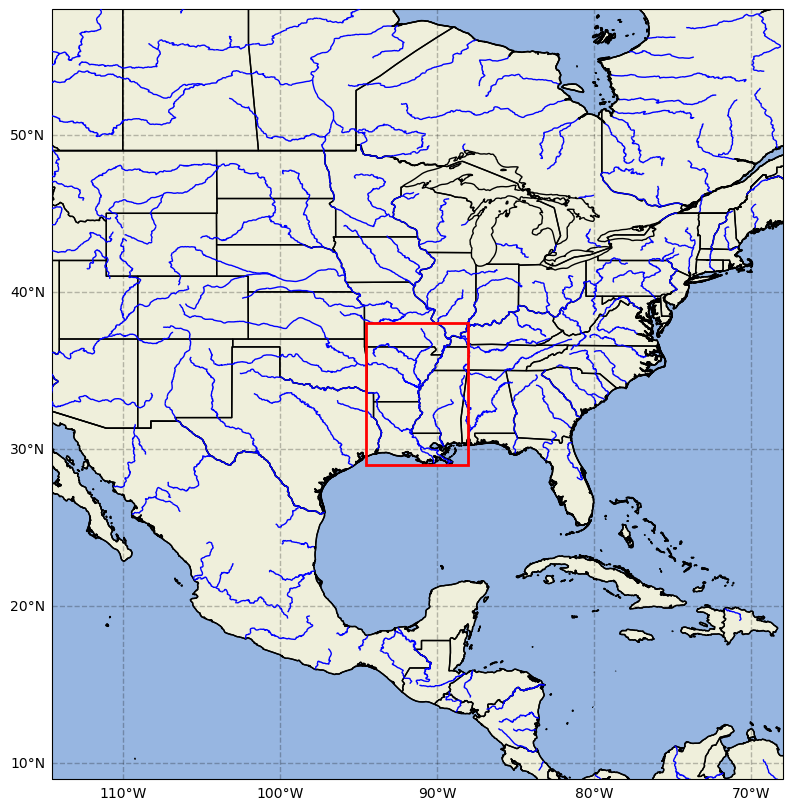

In [18]:
plotting.map_box(MS_surface_runoff_bb)

In [20]:
surface_runoff_timeseries = ideas_processing.spatial_timeseries(*MS_vic_runoff_parameters_qs_acc)
gpm_timeseries_qs_acc = ideas_processing.spatial_timeseries(*MS_gpm_parameters_qs_acc)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GLDAS_VIC10_3H_2_1_global_Qs_acc&minLon=-94.5&minLat=29&maxLon=-88&maxLat=38&startTime=2019-02-14T00:00:00Z&endTime=2019-07-15T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 3.3851175000309013 seconds
url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&minLon=-94.5&minLat=29&maxLon=-88&maxLat=38&startTime=2019-02-14T00:00:00Z&endTime=2019-07-15T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 1.6621622079983354 seconds


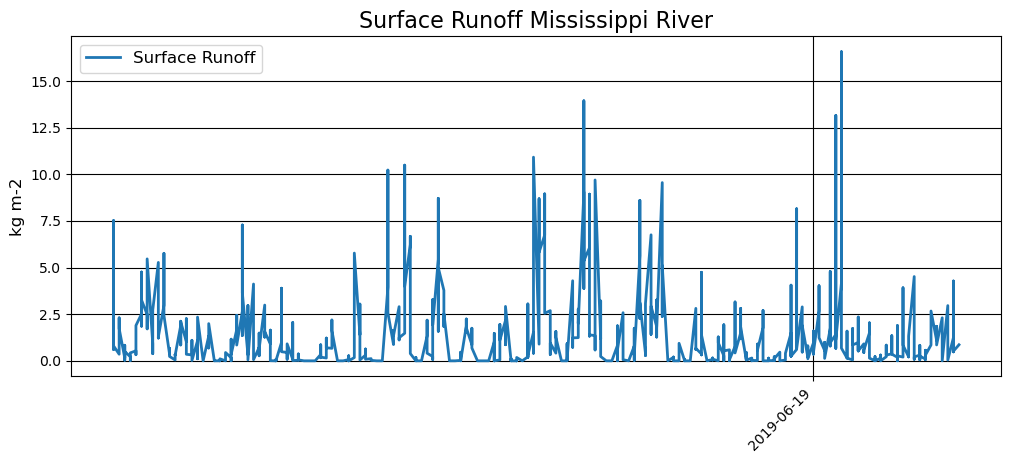

In [21]:
plotting.timeseries_plot([(surface_runoff_timeseries['maximum'], 'Surface Runoff')], '', 'kg m-2', title='Surface Runoff Mississippi River')


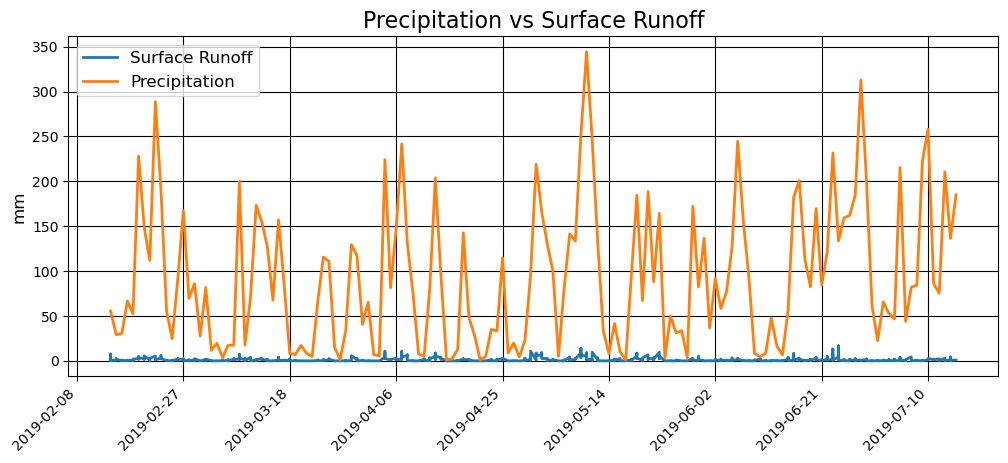

In [22]:
title = f'Mississippi Precipitation Time Series ($mm$)\n{str(MS_surface_runoff_start)[:10]} - {str(MS_surface_runoff_end)[:10]}'
plotting.timeseries_plot([(surface_runoff_timeseries['maximum'], 'Surface Runoff'), (gpm_timeseries_qs_acc['maximum'], 'Precipitation')], '', 'mm', title='Precipitation vs Surface Runoff')


### Subsurface Runoff

In [23]:
global_precipitation_dataset  = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed'
MS_subsurface_runoff_dataset = 'GLDAS_VIC10_3H_2_1_global_Qsb_acc'
MS_subsurface_runoff_bb      = {'min_lon': -94.5, 'max_lon': -88, 'min_lat': 29, 'max_lat': 38}
MS_subsurface_runoff_start   = datetime(2019, 2, 14)
MS_subsurface_runoff_end     = datetime(2019, 7, 15)
MS_vic_runoff_parameters_qsb_acc = (BASE_URL, MS_subsurface_runoff_dataset, MS_subsurface_runoff_bb, MS_subsurface_runoff_start, MS_subsurface_runoff_end)
gpm_parameters_qsb_acc = (BASE_URL, global_precipitation_dataset, MS_subsurface_runoff_bb, MS_subsurface_runoff_start, MS_subsurface_runoff_end)

In [24]:
subsurface_runoff_timeseries = ideas_processing.spatial_timeseries(*MS_vic_runoff_parameters_qsb_acc)
gpm_timeseries_qsb_acc = ideas_processing.spatial_timeseries(*gpm_parameters_qsb_acc)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GLDAS_VIC10_3H_2_1_global_Qsb_acc&minLon=-94.5&minLat=29&maxLon=-88&maxLat=38&startTime=2019-02-14T00:00:00Z&endTime=2019-07-15T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 3.3769206249853596 seconds
url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&minLon=-94.5&minLat=29&maxLon=-88&maxLat=38&startTime=2019-02-14T00:00:00Z&endTime=2019-07-15T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 1.6861977080116048 seconds


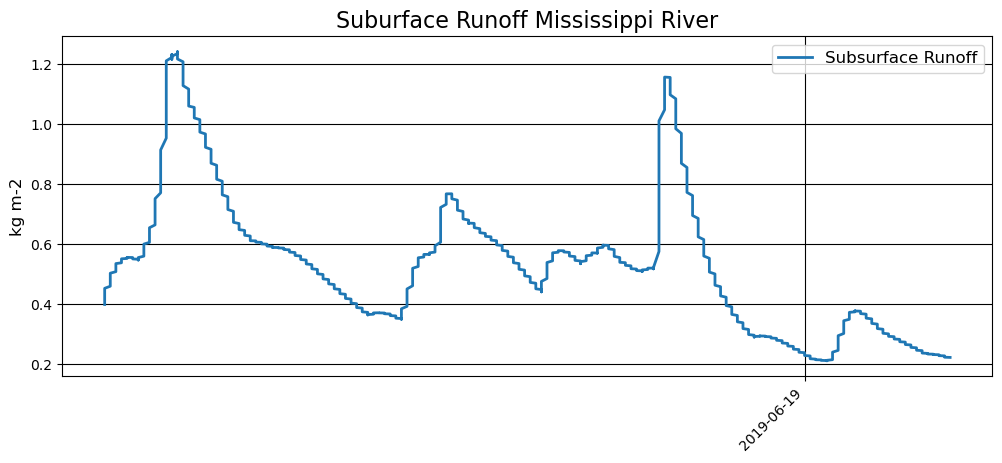

In [25]:
plotting.timeseries_plot([(subsurface_runoff_timeseries['maximum'], 'Subsurface Runoff')], '', 'kg m-2', title='Suburface Runoff Mississippi River')

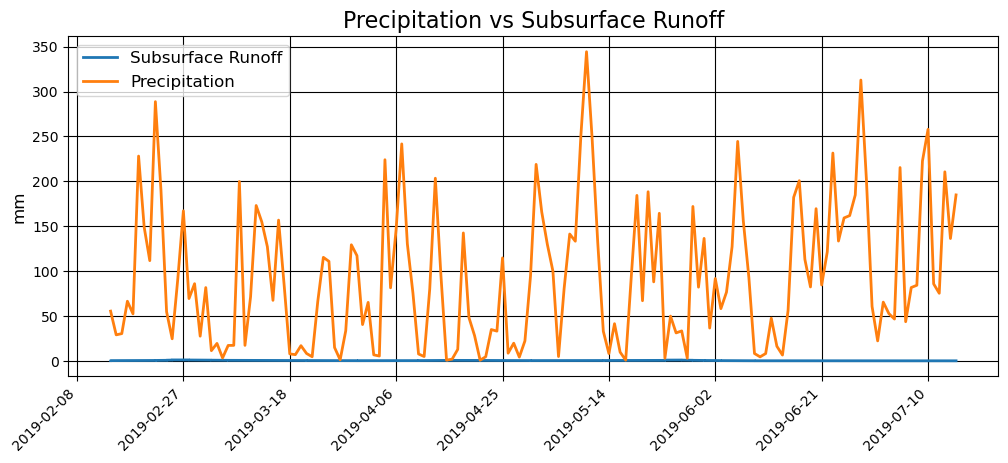

In [26]:
title = f'Mississippi Precipitation Time Series ($mm$)\n{str(MS_subsurface_runoff_start)[:10]} - {str(MS_subsurface_runoff_end)[:10]}'
plotting.timeseries_plot([(subsurface_runoff_timeseries['maximum'], 'Subsurface Runoff'), (gpm_timeseries_qs_acc['maximum'], 'Precipitation')], '', 'mm', title='Precipitation vs Subsurface Runoff')


# LIS

Visualize LIS data.

- data set: LIS-ESoil-tavg
- spatial box:  -108, 32, -84, 42
- temporal box: 2019-12-1 to 2020-1-31

In [ ]:
global_precipitation_dataset  = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed'
soil_dataset = 'LIS-ESoil-tavg'
soil_bb      = {'min_lon': -94.5, 'max_lon': -88, 'min_lat': 29, 'max_lat': 38}
soil_start   = datetime(2020, 1, 1)
soil_end     = datetime(2020, 1, 31)
lis_evap_parameters = (BASE_URL, soil_dataset, soil_bb, soil_start, soil_end)
lis_rain_parameters = (BASE_URL, global_precipitation_dataset, soil_bb, soil_start, soil_end)

In [ ]:
plotting.map_box(soil_bb)

#### Precipitation and Direct Evaporation from Bare Soil 2020-1-1 to 2020-01-31

In [ ]:
lis_evap_timeseries = ideas_processing.spatial_timeseries(*lis_evap_parameters)
lis_rain_timeseries = ideas_processing.spatial_timeseries(*lis_rain_parameters)

#### Precipitation Time Series 2020-1-1 to 2020-01-31

In [ ]:
lis_title = f'Mississippi Precipitation Time Series ($mm$)\n{str(soil_start)[:10]} - {str(soil_end)[:10]}'
plotting.timeseries_plot([(lis_rain_timeseries['maximum'], 'precipitation')], '', '', title=lis_title, norm=False)

#### Normalized Precipitation and Direct Evaporation from Bare Soil 2020-1-1 to 2020-01-31

In [ ]:
lis_title = f'Direct Evaporation from Bare Soil and Precipitation Time Series\n{str(soil_start)[:10]} - {str(soil_end)[:10]}'
plotting.timeseries_plot([(lis_rain_timeseries['maximum'], 'precipitation'), (lis_evap_timeseries['maximum'], 'evaporation')], '', 'Normalized values', title=lis_title, norm=True)

#### Temporal Average of Precipitation and Direct Evaporation from Bare Soil 2020-1-1 to 2020-01-31

In [ ]:
miss_rain_timeavg = ideas_processing.temporal_mean(*lis_rain_parameters)

In [ ]:
plotting.map_data(miss_rain_timeavg, f'Mississippi Average Precipitation ($mm$)\n{str(soil_start)[:10]} - {str(soil_end)[:10]}')

In [ ]:
lis_timeavg = ideas_processing.temporal_mean(*lis_evap_parameters)

In [ ]:
soil_title = f'Average Direct Evaporation from Bare Soil ($kg/m^2/s$)\n{str(soil_start)[:10]} - {str(soil_end)[:10]}'
plotting.map_data(lis_timeavg, soil_title)

#### Latitude Time Hovmöller Analysis

In [ ]:
mis_evap_lat_hof = ideas_processing.hofmoeller(*lis_evap_parameters, dim='latitude')
mis_rain_lat_hof = ideas_processing.hofmoeller(*lis_rain_parameters, dim='latitude')

In [ ]:
mis_rain_hof_title = 'Mississippi Precipitation Latitude Time Hovmöller ($kg/m^2/s$)'
plotting.heatmap(mis_rain_lat_hof['mean'].transpose(), '', 'Latitude', mis_rain_hof_title)

In [ ]:
mis_evap_hof_title = 'Mississippi Average Direct Evaporation from Bare Soil Latitude Time HofMoeller ($kg/m^2/s$)'
plotting.heatmap(mis_evap_lat_hof['mean'].transpose(), '', 'Latitude', mis_evap_hof_title)

#### IDEAS WMS Visual 2020-01-20

In [ ]:
# Connect to IDEAS WMS Service
wms = WebMapService('https://ideas-digitaltwin.jpl.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'LIS_HIST_ESoil_tavg',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-94.5,29,-88,38),  # Bounds
                 size=(400, 550),  # Image size
                 time='2020-01-20',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('LIS_HIST_ESoil_tavg_2020-01-20.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('LIS_HIST_ESoil_tavg_2020-01-20.png')

#### IDEAS WMS Animation 2020-01-01 to 2020-01-31

In [ ]:
wms = WebMapService('https://ideas-digitaltwin.jpl.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'LIS_HIST_ESoil_tavg',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2020, 1, 1)
edate = datetime(2020, 2, 1)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(-94.5,29,-88,38),  # Bounds
                     size=(400, 550),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'LIS ESoil Avg   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('LIS_HIST_ESoil_tavg.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

In [ ]:
Image('LIS_HIST_ESoil_tavg.gif')